References:

https://pylessons.com/A2C-reinforcement-learning/
https://github.com/seungeunrho/minimalRL/blob/master/a2c.py
https://medium.com/deeplearningmadeeasy/advantage-actor-critic-a2c-implementation-944e98616b

In [36]:
import gym
from collections import namedtuple

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.distributions import Categorical

from plot_durations import PlotDurations

In [42]:
##############################################################
# Memory
##############################################################
Transition = namedtuple('Transition',
                        ('log_prob', 'state', 'reward', 'done'))

class Memory(object):
    def __init__(self):
        self.memory = []

    def push(self, *args):
        self.memory.append(Transition(*args))

    def zip(self):
        return Transition(*zip(*self.memory))

    def clear(self):
        self.memory = []

    def reversed(self):
        for data in self.memory[::-1]:
            yield data

    def __len__(self):
        return len(self.memory)

In [43]:
##############################################################
# Model
##############################################################
class Actor(nn.Module):
    def __init__(self, n_observations, n_actions):
        super(Actor, self).__init__()
        self.fc1 = nn.Linear(n_observations, 256)
        self.fc_actor = nn.Linear(256, n_actions)   # Q

    def forward(self, x):  # actor
        x = F.relu(self.fc1(x))
        x = F.softmax(self.fc_actor(x), dim=0)
        return x

class Critic(nn.Module):
    def __init__(self, n_observations):
        super(Critic, self).__init__()
        self.fc1 = nn.Linear(n_observations, 256)
        self.fc_critic = nn.Linear(256, 1)  # V

    def forward(self, x):  # critic says how much reward the actor can take
        x = F.relu(self.fc1(x))
        x = self.fc_critic(x)
        return x

In [44]:
##############################################################
# Training config
##############################################################
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

learning_rate = 1e-3
gamma         = 0.99

env = gym.make('CartPole-v1')
n_actions = env.action_space.n
n_observations = env.observation_space.shape[0]

actor = Actor(n_observations, n_actions).to(device)
critic = Critic(n_observations).to(device)
optimizer_actor = optim.Adam(actor.parameters(), lr=learning_rate)
optimizer_critic = optim.Adam(critic.parameters(), lr=learning_rate)
memory = Memory()

c:\program files (x86)\microsoft visual studio\shared\python37_64\lib\site-packages\gym\logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


In [45]:
##############################################################
# Training
##############################################################
def optimize_model():
    batch = memory.zip()

    R = 0
    reward_batch = list()
    for (_, _, r, done) in memory.reversed():
        R = r + gamma * R * (1.0 - done)
        reward_batch.append(R)
    reward_batch = torch.tensor(reward_batch[::-1], device=device, dtype=torch.float)
    state_batch = torch.tensor(batch.state, device=device, dtype=torch.float)
    value_batch = critic(state_batch).reshape(-1)

    advantage = reward_batch - value_batch

    critic_loss = advantage.pow(2).mean()
    optimizer_critic.zero_grad()
    critic_loss.backward()
    optimizer_critic.step()

    log_prob_batch = torch.stack(batch.log_prob)
    actor_loss = -(log_prob_batch * advantage.detach()).mean()
    optimizer_actor.zero_grad()
    actor_loss.backward()
    optimizer_actor.step()

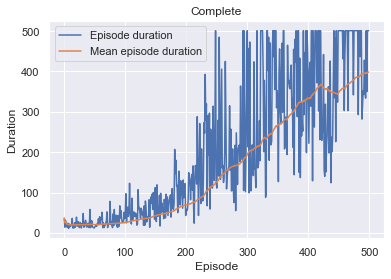

In [46]:
##############################################################
# Training loop
##############################################################
episode_durations = []
for n_epi in range(500):
    s = env.reset()
    done = False

    t = 0
    while not done:  # CartPole-v1 forced to terminates at 500 step.
        prob = actor(torch.tensor(s, device=device, dtype=torch.float))
        dist = Categorical(prob)
        a = dist.sample()

        next_state, r, done, info = env.step(a.item())

        memory.push(dist.log_prob(a), s, r, done)
        s = next_state
        t += 1

    episode_durations.append(t + 1)
    if n_epi % 50 == 0:
        PlotDurations.train_plot(episode_durations)

    optimize_model()
    memory.clear()

env.close()
PlotDurations.complete_plot(episode_durations)

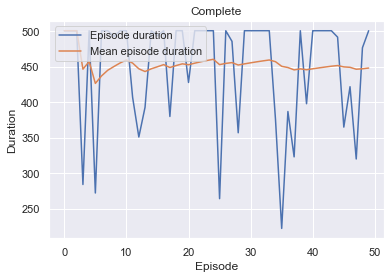

In [47]:
##############################################################
# Testing loop
##############################################################
episode_durations = []
actor.eval()
for i_episode in range(50):
    s = env.reset()
    done = False

    t = 0
    while not done:
        prob = actor(torch.tensor(s, device=device, dtype=torch.float))
        a = Categorical(prob).sample()
        s_prime, r, done, info = env.step(a.item())
        s = s_prime
        t += 1

    episode_durations.append(t + 1)
    if i_episode % 10 == 0:
        PlotDurations.train_plot(episode_durations)

env.close()
PlotDurations.complete_plot(episode_durations)